# Case iFood  - Analista de Dados

# 0.0 - Imports

In [1]:
import pandas               as pd
import numpy                as np
import seaborn               as sns
import matplotlib.pyplot  as plt
from matplotlib.colors import ListedColormap

from matplotlib.ticker  import PercentFormatter

#from ydata_profiling import ProfileReport


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose        import ColumnTransformer
from sklearn.cluster           import KMeans
from sklearn.metrics          import silhouette_score
from sklearn.pipeline          import Pipeline
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler


import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 - Help Functions

In [2]:
def plot_clusters_2D(
    dataframe,
    columns,
    n_colors,
    centroids,
    show_centroids=True,
    show_points=False,
    column_clusters=None,
):
    """Gerar gráfico 2D com os clusters.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Dataframe com os dados.
    columns : List[str]
        Lista com o nome das colunas (strings) a serem utilizadas.
    n_colors : int
        Número de cores para o gráfico.
    centroids : np.ndarray
        Array com os centroides.
    show_centroids : bool, opcional
        Se o gráfico irá mostrar os centroides ou não, por padrão True
    show_points : bool, opcional
        Se o gráfico irá mostrar os pontos ou não, por padrão False
    column_clusters : List[int], opcional
        Coluna com os números dos clusters para colorir os pontos
        (caso mostrar_pontos seja True), por padrão None
    """

    fig = plt.figure()

    ax = fig.add_subplot(111)

    cores = plt.cm.tab10.colors[:n_colors]
    cores = ListedColormap(cores)

    x = dataframe[columns[0]]
    y = dataframe[columns[1]]

    ligar_centroids = show_centroids
    ligar_pontos = show_points

    for i, centroid in enumerate(centroids):
        if ligar_centroids:
            ax.scatter(*centroid, s=500, alpha=0.5)
            ax.text(
                *centroid,
                f"{i}",
                fontsize=20,
                horizontalalignment="center",
                verticalalignment="center",
            )

        if ligar_pontos:
            s = ax.scatter(x, y, c=column_clusters, cmap=cores)
            ax.legend(*s.legend_elements(), bbox_to_anchor=(1.3, 1))

    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title("Clusters")

    plt.show()



#-----------------------------------------------------------------------------------------------------

def plot_columns_percent_hue_cluster(
    dataframe,
    columns,
    rows_cols=(2, 3),
    figsize=(15, 8),
    column_cluster="cluster",
    palette="tab10",
):
    """Função para gerar gráficos de barras com a porcentagem de cada valor com cluster
    como hue.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Dataframe com os dados.
    columns : List[str]
        Lista com o nome das colunas (strings) a serem utilizadas.
    rows_cols : tuple, opcional
        Tupla com o número de linhas e colunas do grid de eixos, por padrão (2, 3)
    figsize : tuple, opcional
        Tupla com a largura e a altura da figura, por padrão (15, 8)
    column_cluster : str, opcional
        Nome da coluna com os números dos clusters, por padrão "cluster"
    palette : str, opcional
        Paleta a ser utilizada, por padrão "tab10"
    """
    fig, axs = plt.subplots(
        nrows=rows_cols[0], ncols=rows_cols[1], figsize=figsize, sharey=True
    )

    if not isinstance(axs, np.ndarray):
        axs = np.array(axs)

    for ax, col in zip(axs.flatten(), columns):
        h = sns.histplot(
            x=col,
            hue=column_cluster,
            data=dataframe,
            ax=ax,
            multiple="fill",
            stat="percent",
            discrete=True,
            shrink=0.8,
            palette=palette,
        )

        if dataframe[col].dtype != "object":
            h.set_xticks(range(dataframe[col].nunique()))

        h.yaxis.set_major_formatter(PercentFormatter(1))
        h.set_ylabel("")
        h.tick_params(axis="both", which="both", length=0)

        for bars in h.containers:
            h.bar_label(
                bars,
                label_type="center",
                labels=[f"{b.get_height():.1%}" for b in bars],
                color="white",
                weight="bold",
                fontsize=11,
            )

        for bar in h.patches:
            bar.set_linewidth(0)

        legend = h.get_legend()
        legend.remove()

    labels = [text.get_text() for text in legend.get_texts()]

    fig.legend(
        handles=legend.legend_handles,
        labels=labels,
        loc="upper center",
        ncols=dataframe[column_cluster].nunique(),
        title="Clusters",
    )

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.show()


#======================================================

def plot_elbow_silhouette(X, random_state=42, range_k=(2, 11)):
    """Gera os gráficos para os métodos Elbow e Silhouette.

    Parameters
    ----------
    X : pandas.DataFrame
        Dataframe com os dados.
    random_state : int, opcional
        Valor para fixar o estado aleatório para reprodutibilidade, por padrão 42
    range_k : tuple, opcional
        Intervalo de valores de cluster, por padrão (2, 11)
    """

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), tight_layout=True)

    elbow = {}
    silhouette = []

    k_range = range(*range_k)

    for i in k_range:
        kmeans = KMeans(n_clusters=i, random_state=random_state, n_init=10)
        kmeans.fit(X)
        elbow[i] = kmeans.inertia_

        labels = kmeans.labels_
        silhouette.append(silhouette_score(X, labels))

    sns.lineplot(x=list(elbow.keys()), y=list(elbow.values()), ax=axs[0])
    axs[0].set_xlabel("K")
    axs[0].set_xlabel("Inertia")
    axs[0].set_title("Elbow Method")

    sns.lineplot(x=list(k_range), y=silhouette, ax=axs[1])
    axs[1].set_xlabel("K")
    axs[1].set_xlabel("Silhouette Score")
    axs[1].set_title("Silhouette Method")

    plt.show()


## 0.2 - Load dataset

In [3]:
df_raw = pd.read_csv ('../data/ml_project1_data.csv' , sep ='\t')

In [4]:
df_raw.head(2)

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  

[2 rows x 29 columns]

# 1.0 - Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 - Dimensão dos dados

In [6]:
print (' O numero de linhas: {}'.format(df1.shape[0]))
print (' O numero de colunas: {}'.format(df1.shape[1]))

 O numero de linhas: 2240
 O numero de colunas: 29


## 1.2 - Informações dos dados

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## 1.3 - Check os NA

In [8]:
df1.isna().sum().sort_values(ascending=False).head()

Income            24
ID                 0
Year_Birth         0
Education          0
Marital_Status     0
dtype: int64

## 1.4 - Replace NA

In [9]:
# Como a quantidade é bem baixa,retirando NaN por ser apenas 1% da base
df1 = df1.dropna()

## 

## 1.5 - Estatistica descritiva

In [10]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64' , 'float64', 'datetime64[ns]'])

### 1.5.1 - Numerical Attributes

In [11]:
#central tendency 
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# dispersion ---- desvio padrao, max, min, range, skew, kurtosis
d1= pd.DataFrame(num_attributes.apply( (np.std ))).T 
d2= pd.DataFrame(num_attributes.apply( np.max )).T 
d3= pd.DataFrame(num_attributes.apply( np.min )).T 
d4= pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T 
d5= pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T 
d6= pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T 

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = [ 'attributes', 'max' , 'min' , 'range' , 'mean' , 'mediana' , 'std' , 'skew' , 'kurtosis' ]
m.round(3)

attributes       max     min     range       mean  mediana  \
0                    ID   11191.0     0.0   11191.0   5588.353   5458.5   
1            Year_Birth    1996.0  1893.0     103.0   1968.820   1970.0   
2                Income  666666.0  1730.0  664936.0  52247.251  51381.5   
3               Kidhome       2.0     0.0       2.0      0.442      0.0   
4              Teenhome       2.0     0.0       2.0      0.505      0.0   
5               Recency      99.0     0.0      99.0     49.013     49.0   
6              MntWines    1493.0     0.0    1493.0    305.092    174.5   
7             MntFruits     199.0     0.0     199.0     26.356      8.0   
8       MntMeatProducts    1725.0     0.0    1725.0    166.996     68.0   
9       MntFishProducts     259.0     0.0     259.0     37.638     12.0   
10     MntSweetProducts     262.0     0.0     262.0     27.029      8.0   
11         MntGoldProds     321.0     0.0     321.0     43.965     24.5   
12    NumDealsPurchases      15.0     0.0      15.0      2.324      2.0   
13      NumWebPurchases      27.0     0.0      27.0      4.085      4.0   
14  NumCatalogPurchases      28.0     0.0      28.0      2.671      2.0   
15    NumStorePurchases      13.0     0.0      13.0      5.801      5.0   
16    NumWebVisitsMonth      20.0     0.0      20.0      5.319      6.0   
17         AcceptedCmp3       1.0     0.0       1.0      0.074      0.0   
18         AcceptedCmp4       1.0     0.0       1.0      0.074      0.0   
19         AcceptedCmp5       1.0     0.0       1.0      0.073      0.0   
20         AcceptedCmp1       1.0     0.0       1.0      0.064      0.0   
21         AcceptedCmp2       1.0     0.0       1.0      0.014      0.0   
22             Complain       1.0     0.0       1.0      0.009      0.0   
23        Z_CostContact       3.0     3.0       0.0      3.000      3.0   
24            Z_Revenue      11.0    11.0       0.0     11.000     11.0   
25             Response       1.0     0.0       1.0      0.150      0.0   

          std    skew  kurtosis  
0    3248.643   0.040    -1.190  
1      11.983  -0.354     0.735  
2   25167.396   6.763   159.637  
3       0.537   0.636    -0.791  
4       0.544   0.408    -0.990  
5      28.942   0.002    -1.200  
6     337.252   1.171     0.583  
7      39.785   2.102     4.054  
8     224.233   2.026     5.055  
9      54.740   1.916     3.076  
10     41.063   2.103     4.106  
11     51.804   1.839     3.156  
12      1.923   2.415     8.974  
13      2.740   1.197     4.072  
14      2.926   1.881     8.067  
15      3.250   0.702    -0.626  
16      2.425   0.218     1.853  
17      0.261   3.269     8.697  
18      0.262   3.257     8.614  
19      0.260   3.282     8.780  
20      0.245   3.562    10.701  
21      0.116   8.425    69.039  
22      0.097  10.133   100.763  
23      0.000   0.000     0.000  
24      0.000   0.000     0.000  
25      0.357   1.959     1.838

## 1.5.2 - Categorical Attributes

In [12]:
cat_attributes.describe()

Education Marital_Status Dt_Customer
count         2216           2216        2216
unique           5              8         662
top     Graduation        Married  31-08-2012
freq          1116            857          12

# 2.0 - Filtragem da Variavéis

In [13]:
df2 = df1.copy()

In [14]:
#transformando tipo da coluna para data
df2[ 'Dt_Customer'] = pd.to_datetime(df2['Dt_Customer'], format="%d-%m-%Y")

# retirando os outliers da coluna Age 
df2= df2[~df2['ID'].isin( [7829 ,11004, 1150] )]

# bad users , informacao aleatoria na coluna income
df2 = df2[~df2['ID'].isin( [9432] )]

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2212 non-null   int64         
 1   Year_Birth           2212 non-null   int64         
 2   Education            2212 non-null   object        
 3   Marital_Status       2212 non-null   object        
 4   Income               2212 non-null   float64       
 5   Kidhome              2212 non-null   int64         
 6   Teenhome             2212 non-null   int64         
 7   Dt_Customer          2212 non-null   datetime64[ns]
 8   Recency              2212 non-null   int64         
 9   MntWines             2212 non-null   int64         
 10  MntFruits            2212 non-null   int64         
 11  MntMeatProducts      2212 non-null   int64         
 12  MntFishProducts      2212 non-null   int64         
 13  MntSweetProducts     2212 non-null   i

# 3.0 - Feature Enginnering

In [16]:
df3 = df2.copy()

## 3.1 - Days Since Enrolled

- Em quantos dias esse cliente esta cadastrado

In [17]:
df3['DaysSinceEnrolled'] = df3['Dt_Customer'].max() - df3['Dt_Customer']
df3['DaysSinceEnrolled'] = df3['DaysSinceEnrolled'].dt.days

## 3.2 - Years Since Enrolled

- Em quantos anos o cliente esta cadastrado

In [18]:
df3['YearsSinceEnrolled'] = df3['DaysSinceEnrolled'] // 365

In [19]:
df3['YearsSinceEnrolled'].value_counts()

YearsSinceEnrolled
0    1141
1    1071
Name: count, dtype: int64

## 3.3 - Age

- Idade do cliente de quando a coleta dos dados foi feita

In [20]:
df3['Age'] = df3['Dt_Customer'].max().year - df3['Year_Birth']

In [21]:
df3['Age'].describe()

count    2212.000000
mean       45.086347
std        11.701599
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64

**Grupos de idade**

- adulto_jovem = 18 a 30 anos

- adulto = 31 a 45 anos

- adulto_senior = 46 a 60 anos

- idoso > 60 anos

In [22]:
df3['AgeGroup'] = pd.cut(
    df3['Age'],
    bins=[18, 30, 45, 60, df3['Age'].max()],
    labels=['18-30' , '31-45', '46-60', '61+'],
    include_lowest=True
)

In [23]:
df3['AgeGroup'].value_counts()

AgeGroup
31-45    964
46-60    727
61+      264
18-30    257
Name: count, dtype: int64

## 3.4 - MntTotal e MntRegularProds

- MntTotal : Coluna com o total de produtos disponiveis na base,os regulares + 'gold'
- MntRegularProds: soma total dos produtos regulares

In [24]:
df3.loc[:, df3.columns.str.startswith("Mnt")].head(2)

MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0       635         88              546              172                88   
1        11          1                6                2                 1   

   MntGoldProds  
0            88  
1             6

In [25]:
df3['MntTotal']= (
    df3['MntWines']
    + df3['MntFruits']
    + df3['MntMeatProducts']
    + df3['MntFishProducts']
    + df3['MntSweetProducts']
    + df3['MntGoldProds']
)

df3['MntRegularProds'] = df3['MntTotal'] - df3['MntGoldProds']

## 3.5 - Children 

-  As duas colunas Kidhome e Teenhome passa a irformação dependentes sendo criança ou adolescentes, respectivamente. Como não sei foi realizado a distinção para classificar entre criança e adolescentes, irei juntar em uma coluna para obter a informacao se o cliente tem dependentes e em qual quantidade ou se não tem.

In [26]:
df3['Children'] = df3['Kidhome'] + df3['Teenhome']

### 3.5.1 - HasChildren
- Coluna com a informação se tem dependentes ou não

In [27]:
df3['HasChildren'] = df3['Children'].apply( lambda x: 1 if x > 0 else 0)

In [28]:
df3['HasChildren'].value_counts()

HasChildren
1    1580
0     632
Name: count, dtype: int64

## 3.6 - Marital_Status

- Coluna que obtem a informacao do estado civil do cliente, a fim de simplificar irei classificar assim:

    0: Cliente não tem parceiro
    
    1: Cliente tem parceiro

In [29]:
df3['Marital_Status'] = df3['Marital_Status'].replace(
    {
        'Alone'      :  'Single',
        'Absurd'    : 'Single',
        'YOLO'      : 'Single',
        'Divorced' : 'Single',
        'Widow'    : 'Single',
        'Single'     : 'Single',
        'Married'   : 'Partner',
        'Together' : 'Partner'
    }
)

In [30]:
df3['Marital_Status'].value_counts()

Marital_Status
Partner    1428
Single      784
Name: count, dtype: int64

## 3.7 - AcceptedCmpTotal

 - Coluna para saber quantas campanhas o cliente participou



In [31]:
# total de vezes que cliente participou das campanhas de marketing
df3['AcceptedCmpTotal'] = (
    df3['AcceptedCmp1' ]+
    df3['AcceptedCmp2' ]+
    df3['AcceptedCmp3' ]+
    df3['AcceptedCmp4' ]+
    df3['AcceptedCmp5' ]
)

# coluna indicadora com a informacao se o cliente participo ou nao 
df3['HasAcceptedCmp'] = df3['AcceptedCmpTotal'].apply( lambda x: 1 if x > 0 else 0)

In [32]:
df3['AcceptedCmpTotal'].value_counts()

AcceptedCmpTotal
0    1754
1     322
2      81
3      44
4      11
Name: count, dtype: int64

In [33]:
df3['HasAcceptedCmp'].value_counts()

HasAcceptedCmp
0    1754
1     458
Name: count, dtype: int64

## 3.8 - NumTotalPurchase

- Numero total de compras

In [34]:
df3['NumTotalPurchase'] = (
    df3['NumWebPurchases']
    + df3['NumStorePurchases']
    + df3['NumCatalogPurchases']
)

In [35]:
df3['NumTotalPurchase'].value_counts().head()

NumTotalPurchase
4    200
6    188
5    178
7    126
3    124
Name: count, dtype: int64

# 4.0 - Análise Exploratória de Dados - EDA


In [36]:
df4 = df3.copy()

In [37]:
#profile = ProfileReport(df2)
#profile.to_file('../reports/eda.html')

## 4.1 - Tratando Outliers

### Analisando os outliers das colunas Age, Income e MntTotal

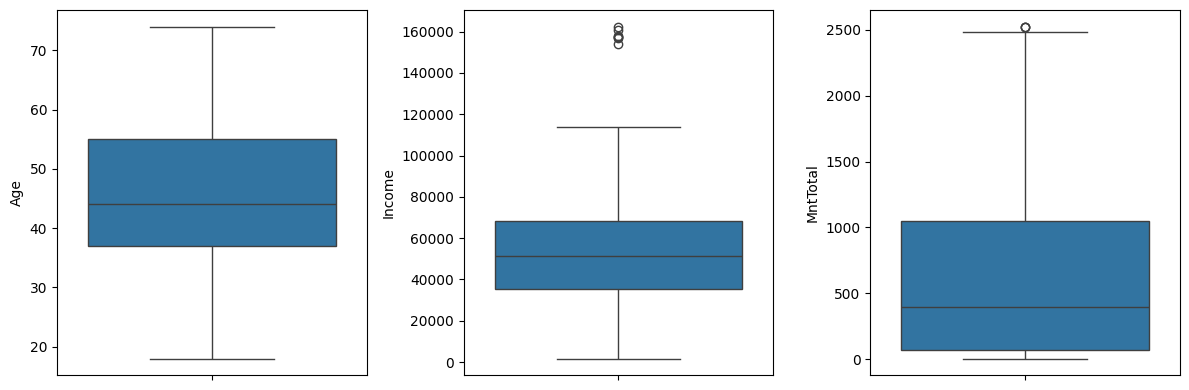

In [38]:
search_outlier = ['Age' , 'Income' , 'MntTotal']

fig, axs = plt.subplots( nrows=1, ncols=3 , figsize=(12,4) , tight_layout = True)

for i, column in enumerate (search_outlier):
    sns.boxplot( y=column , data=df4 , ax=axs[i]) 

plt.show()


### 4.2.1 - Age

In [39]:
df4['Age'].describe()

count    2212.000000
mean       45.086347
std        11.701599
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64

In [40]:
#localizando os outliers da coluna Age e removendo da base

#df_aux = df4.loc[df4['Age'] > (55*1.5), ['ID' , 'Year_Birth','Age']]

#df4 = df4[~df4['ID'].isin( [7829 ,11004, 1150] )]


In [41]:
df4['Age'].describe()

count    2212.000000
mean       45.086347
std        11.701599
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64

### 4.2.2 - Income

In [42]:
df4['Income'].describe()

count      2212.000000
mean      51958.810579
std       21527.278844
min        1730.000000
25%       35233.500000
50%       51371.000000
75%       68487.000000
max      162397.000000
Name: Income, dtype: float64

In [43]:
#localizando os outliers da coluna Income 

#df_aux = df4.loc[df4['Income'] > (68487*1.5), ['ID' , 'Income']]
#df4 = df4.drop(df_aux.index)

In [44]:
#aparentemente, cliiente informou sua renda de forma aleatoria, sendo assim sera removida essa linha 

#df4[df4['Income'] == 666666.0]

# bad users
#df4 = df4[~df4['ID'].isin( [9432] )]


### 4.2.3 - MntTotal

In [45]:
df4['MntTotal'].describe()

count    2212.000000
mean      607.268083
std       602.513364
min         5.000000
25%        69.000000
50%       397.000000
75%      1048.000000
max      2525.000000
Name: MntTotal, dtype: float64

In [46]:
df4.loc[: , ['ID' ,'MntTotal']].sort_values('MntTotal', ascending=False).head(10)

ID  MntTotal
1572   5350      2525
1179   5735      2525
1492   1763      2524
987    4580      2486
1052   4475      2440
1601   5453      2352
1458  10133      2349
1288   9010      2346
943    5386      2302
1301   6024      2302

#### Os dados de Outliers na coluna MntTotal não tem muita discrepância com os demais dados, sendo  assim , irei manter todas suas informações.

## 4.2 - Removendo Colunas

Na etapa de Feature Enginnering derivamos algumas colunas, então irei excluir as que obtem a mesma informaçao, e tambem 
remover as que não possui informacao relevante para a continuação do projeto.

In [47]:
df4 = df4.drop(
    [
        'ID',
        'Year_Birth',
        'Dt_Customer',
        'Z_CostContact',
        'Z_Revenue',
        'Kidhome',
        'Teenhome'
    ],axis =1 
)

In [48]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2212 non-null   object  
 1   Marital_Status       2212 non-null   object  
 2   Income               2212 non-null   float64 
 3   Recency              2212 non-null   int64   
 4   MntWines             2212 non-null   int64   
 5   MntFruits            2212 non-null   int64   
 6   MntMeatProducts      2212 non-null   int64   
 7   MntFishProducts      2212 non-null   int64   
 8   MntSweetProducts     2212 non-null   int64   
 9   MntGoldProds         2212 non-null   int64   
 10  NumDealsPurchases    2212 non-null   int64   
 11  NumWebPurchases      2212 non-null   int64   
 12  NumCatalogPurchases  2212 non-null   int64   
 13  NumStorePurchases    2212 non-null   int64   
 14  NumWebVisitsMonth    2212 non-null   int64   
 15  AcceptedCmp3         2212 

## 4.3 - Análise Univariada

In [49]:
#profile = ProfileReport(df4)
#profile.to_file('../reports/eda_v2.html')

In [50]:
with pd.option_context(
    'display.float_format', '{:.2f}'.format,
    'display.max_columns', None,
):
    display(df4.describe() )

Income  Recency  MntWines  MntFruits  MntMeatProducts  \
count   2212.00  2212.00   2212.00    2212.00          2212.00   
mean   51958.81    49.02    305.29      26.33           167.03   
std    21527.28    28.94    337.32      39.74           224.25   
min     1730.00     0.00      0.00       0.00             0.00   
25%    35233.50    24.00     24.00       2.00            16.00   
50%    51371.00    49.00    175.50       8.00            68.00   
75%    68487.00    74.00    505.00      33.00           232.25   
max   162397.00    99.00   1493.00     199.00          1725.00   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count          2212.00           2212.00       2212.00            2212.00   
mean             37.65             27.05         43.93               2.32   
std              54.77             41.09         51.71               1.92   
min               0.00              0.00          0.00               0.00   
25%               3.00              1.00          9.00               1.00   
50%              12.00              8.00         24.50               2.00   
75%              50.00             33.00         56.00               3.00   
max             259.00            262.00        321.00              15.00   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count          2212.00              2212.00            2212.00   
mean              4.09                 2.67               5.81   
std               2.74                 2.93               3.25   
min               0.00                 0.00               0.00   
25%               2.00                 0.00               3.00   
50%               4.00                 2.00               5.00   
75%               6.00                 4.00               8.00   
max              27.00                28.00              13.00   

       NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
count            2212.00       2212.00       2212.00       2212.00   
mean                5.32          0.07          0.07          0.07   
std                 2.43          0.26          0.26          0.26   
min                 0.00          0.00          0.00          0.00   
25%                 3.00          0.00          0.00          0.00   
50%                 6.00          0.00          0.00          0.00   
75%                 7.00          0.00          0.00          0.00   
max                20.00          1.00          1.00          1.00   

       AcceptedCmp1  AcceptedCmp2  Complain  Response  DaysSinceEnrolled  \
count       2212.00       2212.00   2212.00   2212.00            2212.00   
mean           0.06          0.01      0.01      0.15             353.71   
std            0.25          0.12      0.09      0.36             202.49   
min            0.00          0.00      0.00      0.00               0.00   
25%            0.00          0.00      0.00      0.00             180.00   
50%            0.00          0.00      0.00      0.00             356.00   
75%            0.00          0.00      0.00      0.00             529.00   
max            1.00          1.00      1.00      1.00             699.00   

       YearsSinceEnrolled     Age  MntTotal  MntRegularProds  Children  \
count             2212.00 2212.00   2212.00          2212.00   2212.00   
mean                 0.48   45.09    607.27           563.34      0.95   
std                  0.50   11.70    602.51           576.93      0.75   
min                  0.00   18.00      5.00             4.00      0.00   
25%                  0.00   37.00     69.00            55.75      0.00   
50%                  0.00   44.00    397.00           343.00      1.00   
75%                  1.00   55.00   1048.00           964.00      1.00   
max                  1.00   74.00   2525.00          2491.00      3.00   

       HasChildren  AcceptedCmpTotal  HasAcceptedCmp  NumTotalPurchase  
count      2212.00           2212.00         2212.00           2212.0

## 4.4 - Análise Bivariada

 Selecionando algumas colunas que julgo ser mais interessante para visualizar graficamente a fim de encontrar insights 

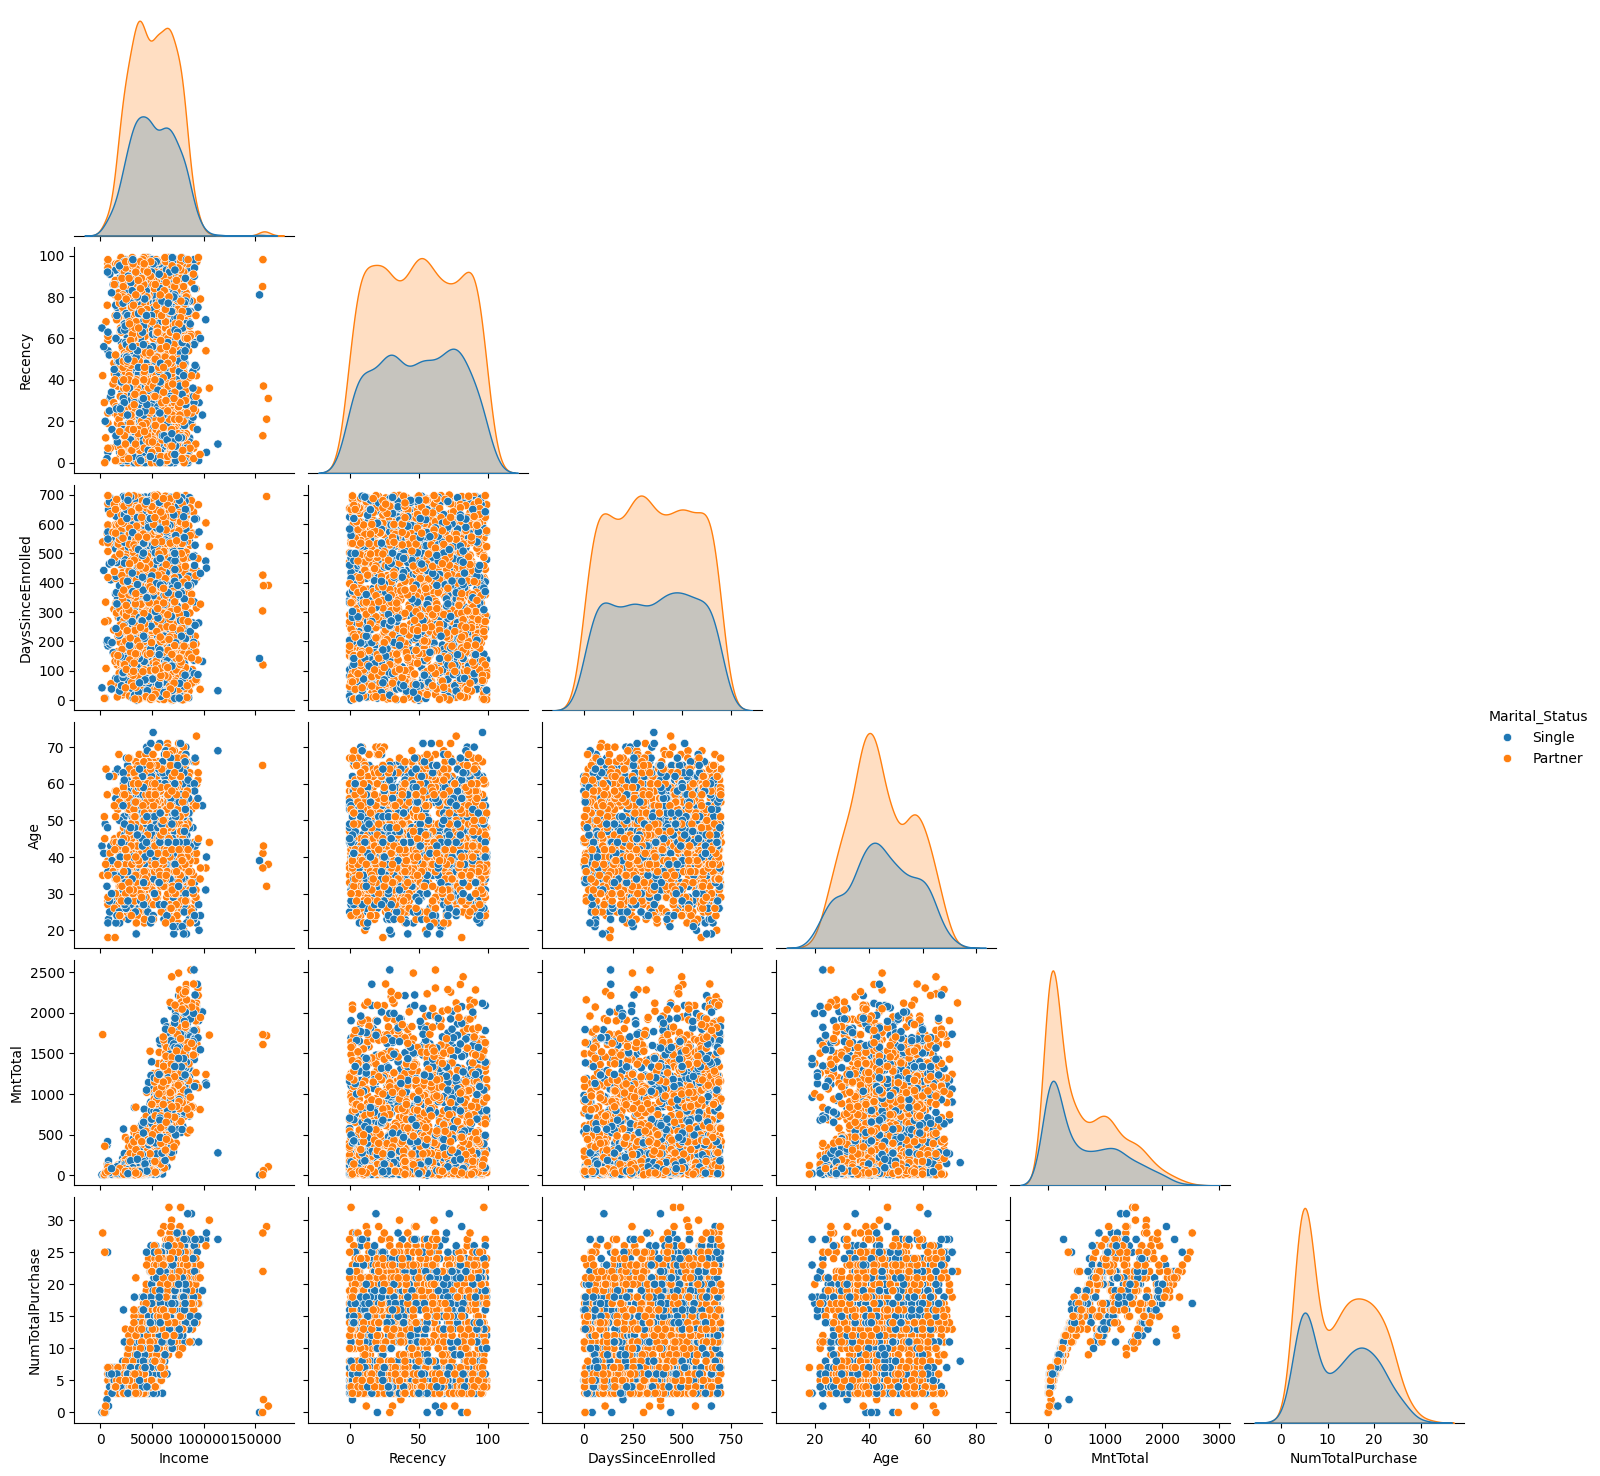

In [51]:
select_columns = [
    'Income',
    'Recency',
    'DaysSinceEnrolled',
    'Age',
    'MntTotal',
    'NumTotalPurchase',
    'Marital_Status'
]

sns.pairplot (df4[select_columns] , diag_kind='kde' , hue = 'Marital_Status' , corner=True)

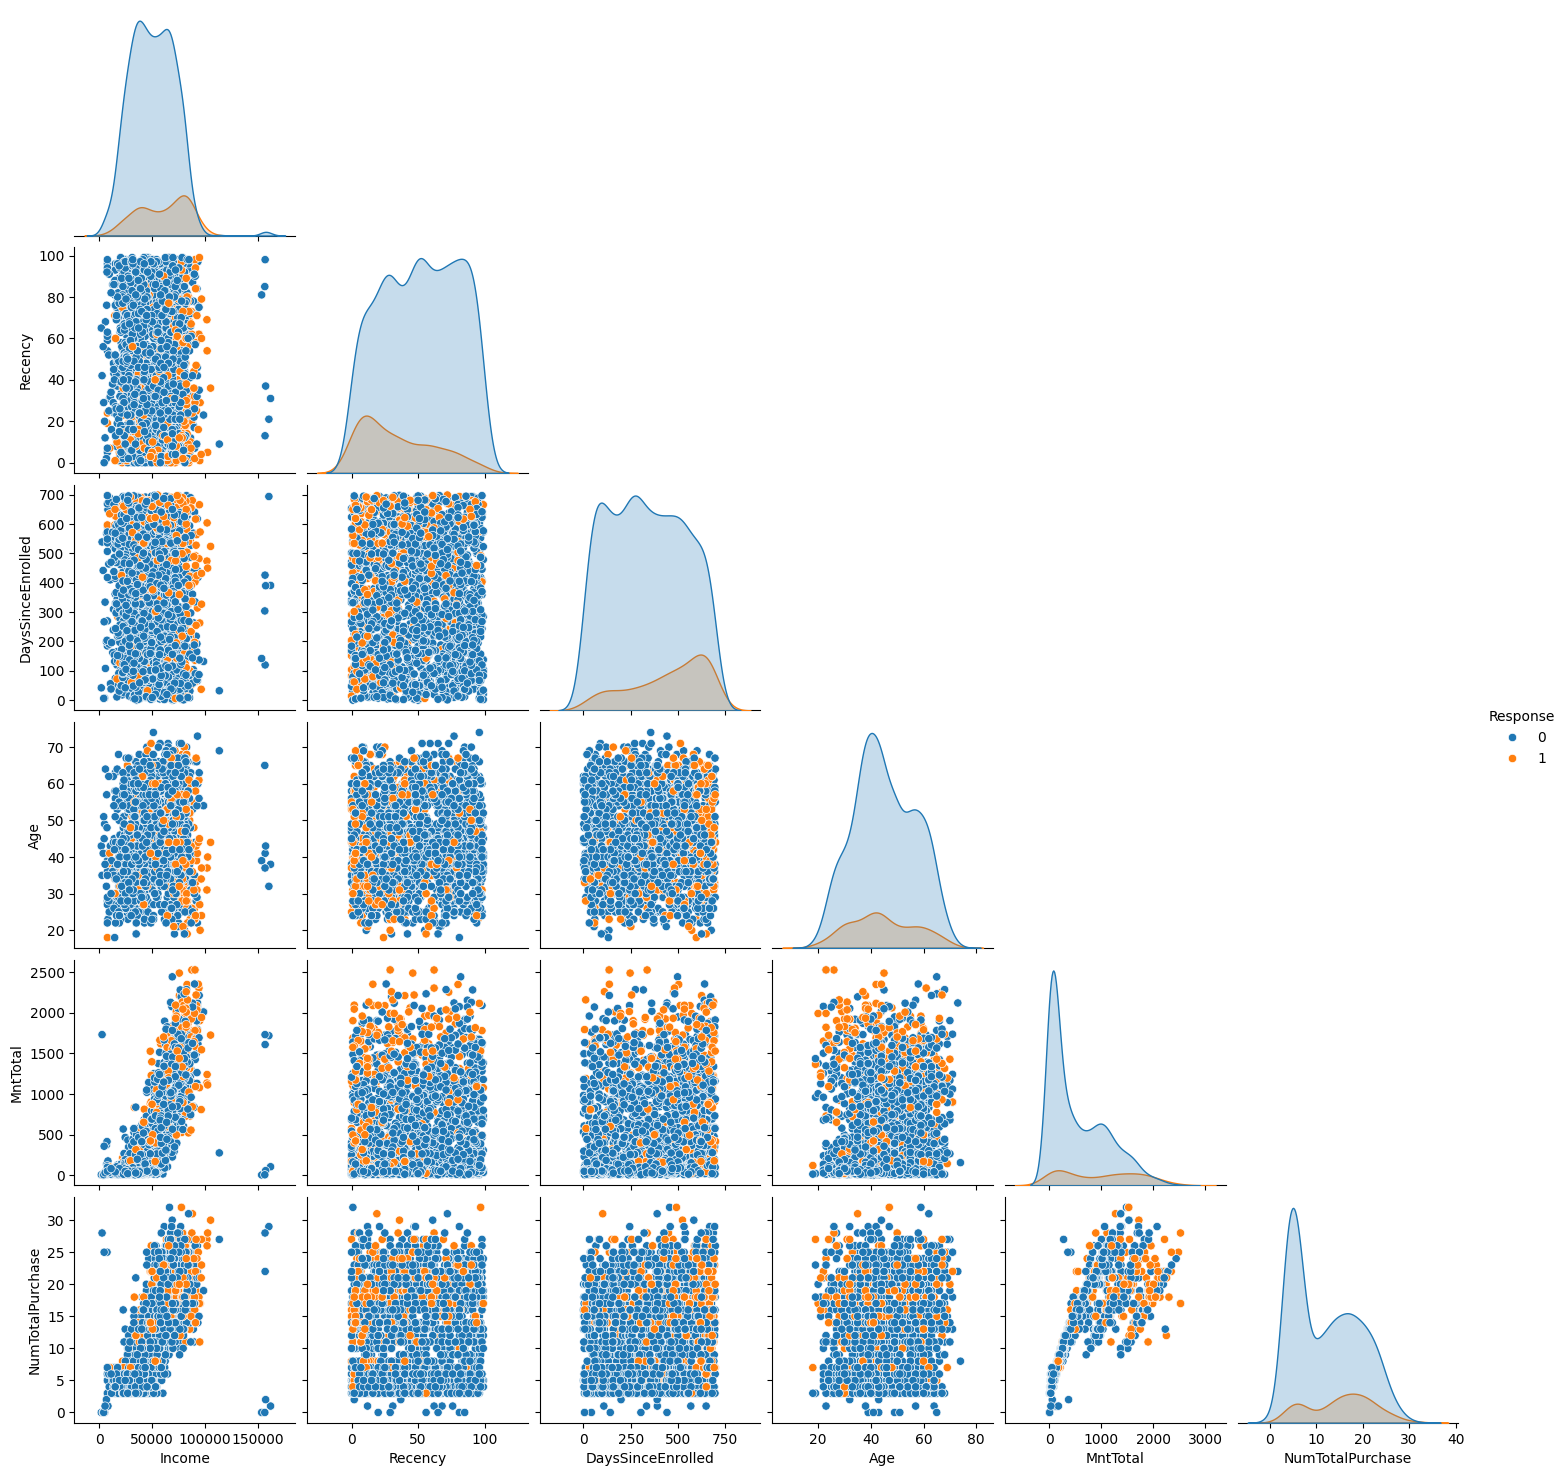

In [52]:
select_columns = [
    'Income',
    'Recency',
    'DaysSinceEnrolled',
    'Age',
    'MntTotal',
    'NumTotalPurchase',
    'Response'
]

sns.pairplot (df4[select_columns] , diag_kind='kde' , hue = 'Response' , corner=True)

### 4.4.1 - Boxplot com informações de Educação, Renda e Tem filhos ou não

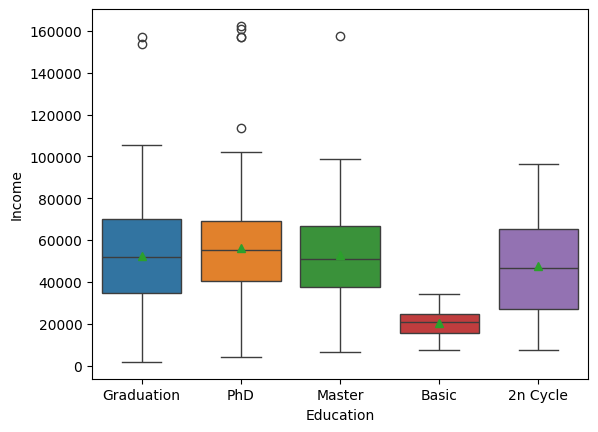

In [53]:
sns.boxplot(x= 'Education', y='Income' , data= df4 , showmeans=True , hue='Education');

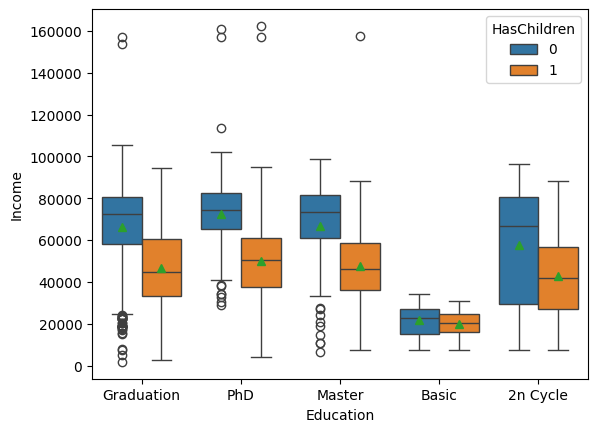

In [54]:
sns.boxplot(x= 'Education', y='Income' , data= df4 , showmeans=True , hue='HasChildren');

### 4.4.2 - Boxplot com informações de Educação, Renda e Tem parceiro ou não

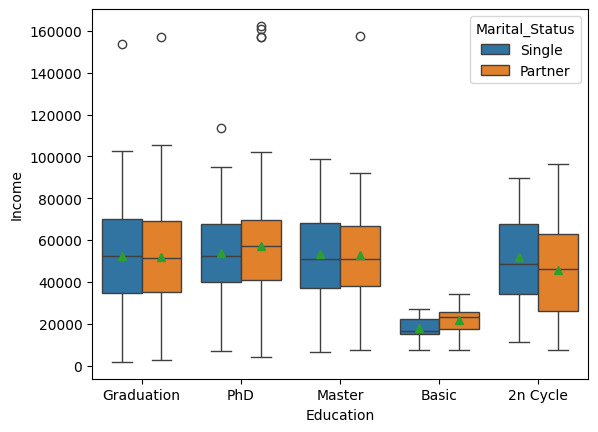

In [55]:
sns.boxplot(x= 'Education', y='Income' , data= df4 , showmeans=True , hue='Marital_Status');

### 4.4.3 - Boxplot com informações por Grupo de Idade, Renda e Tem filhos ou não

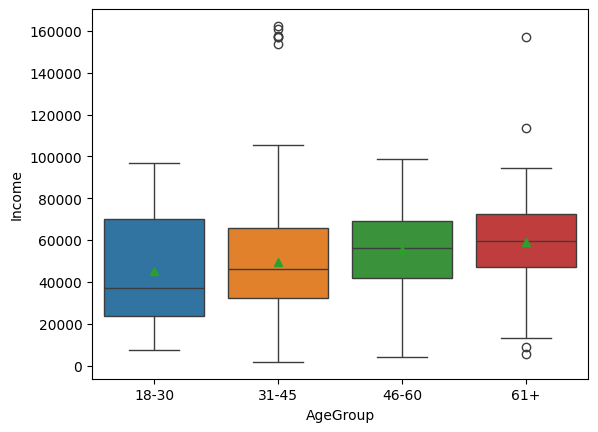

In [56]:
sns.boxplot(x= 'AgeGroup', y='Income' , data= df4 , showmeans=True , hue='AgeGroup');


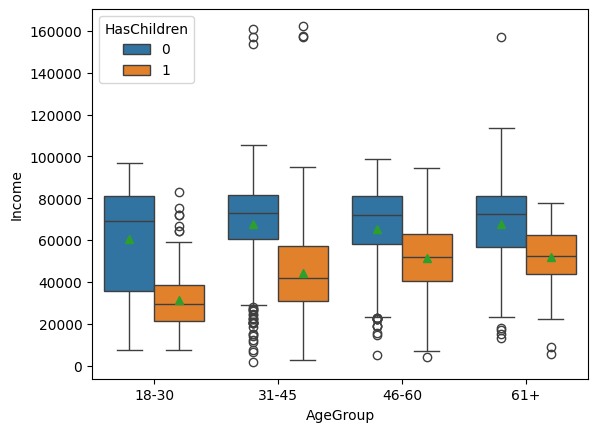

In [57]:
sns.boxplot(x= 'AgeGroup', y='Income' , data= df4 , showmeans=True , hue='HasChildren');

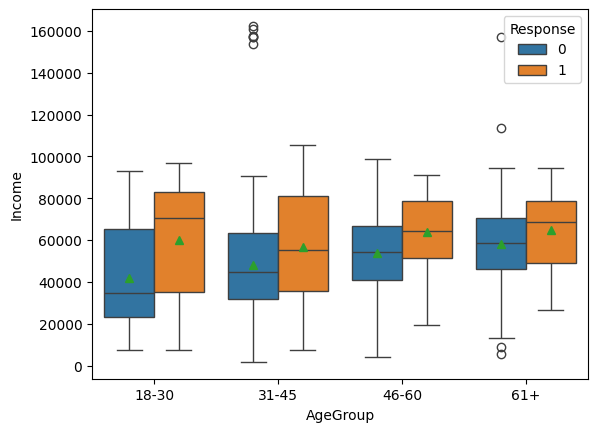

In [58]:
sns.boxplot(x= 'AgeGroup', y='Income' , data= df4 , showmeans=True , hue='Response');

## 4.5 - Correlações

In [59]:
#transformando as colunas categoricas em numericas
df4_dummies = pd.get_dummies(df4 ,dtype =int)

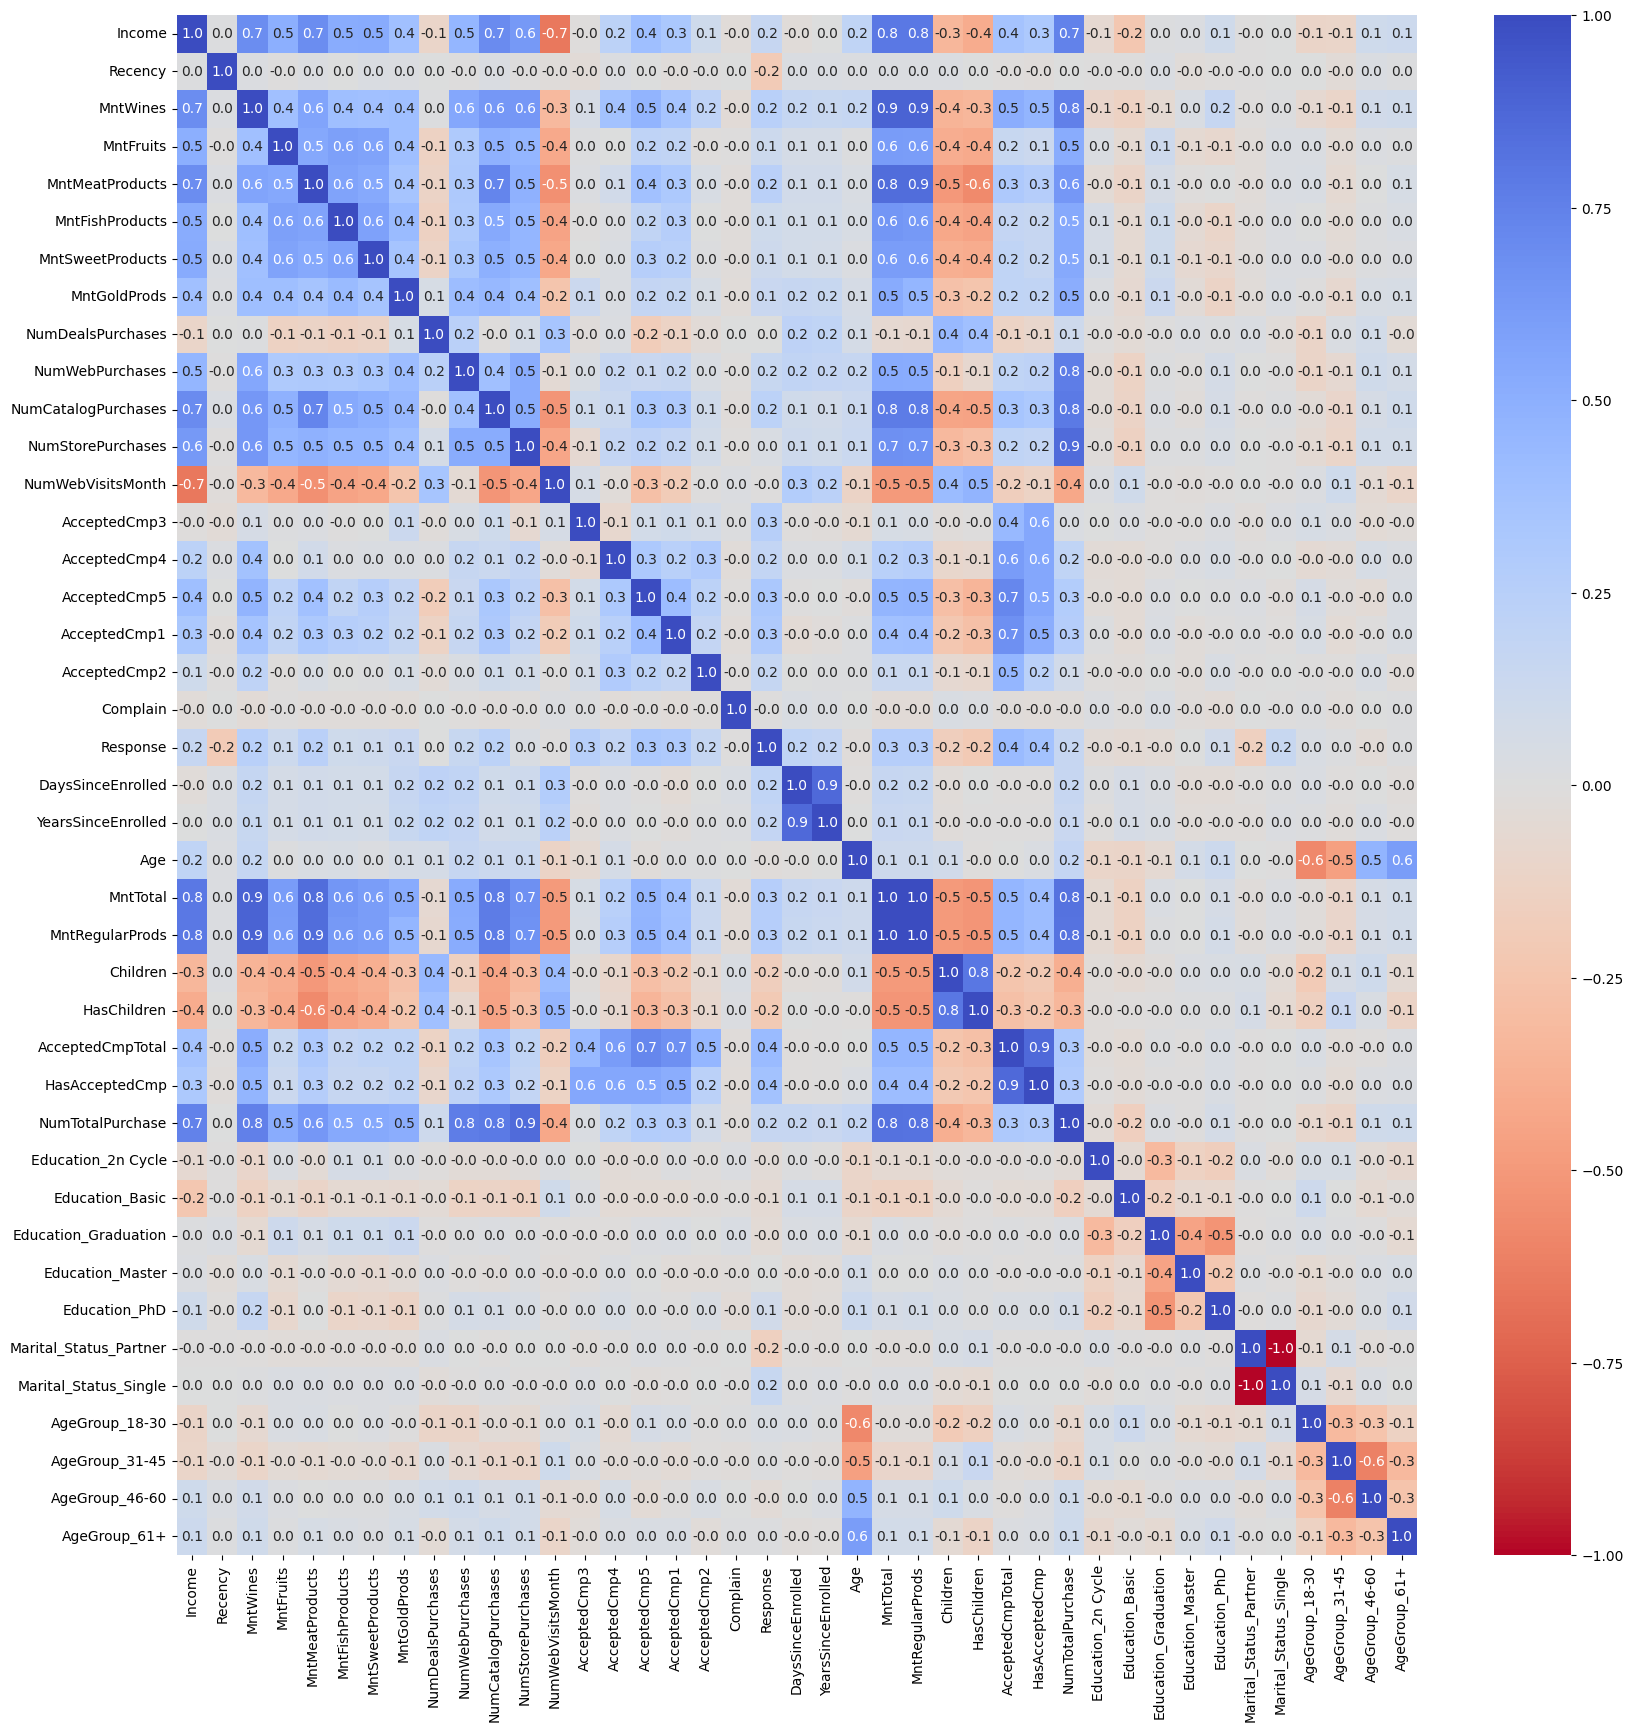

In [60]:
df4_dummies_corr = df4_dummies.corr()

fig, ax = plt.subplots(figsize =(20,20))

sns.heatmap(df4_dummies_corr , annot=True , ax=ax , fmt=".1f", cmap="coolwarm_r");

In [61]:
df_dummies_corr_unstack = pd.DataFrame(df4_dummies_corr.unstack())
df_dummies_corr_unstack = df_dummies_corr_unstack.rename(columns={0: "corr"})

In [62]:
# correlacao da renda com demais colunas
df_dummies_corr_unstack.loc["Income"].sort_values(by="corr")

corr
NumWebVisitsMonth      -0.650257
HasChildren            -0.403132
Children               -0.343529
Education_Basic        -0.232642
AgeGroup_18-30         -0.113254
NumDealsPurchases      -0.108207
AgeGroup_31-45         -0.107563
Education_2n Cycle     -0.063132
Complain               -0.027900
DaysSinceEnrolled      -0.023760
AcceptedCmp3           -0.015152
Marital_Status_Partner -0.004803
YearsSinceEnrolled      0.000595
Marital_Status_Single   0.004803
Recency                 0.007965
Education_Graduation    0.009881
Education_Master        0.019802
Education_PhD           0.101006
AcceptedCmp2            0.104036
AgeGroup_46-60          0.107649
AgeGroup_61+            0.120488
Response                0.161387
Age                     0.199977
AcceptedCmp4            0.219633
HasAcceptedCmp          0.314752
AcceptedCmp1            0.327524
AcceptedCmpTotal        0.365986
MntGoldProds            0.388299
AcceptedCmp5            0.395569
NumWebPurchases         0.459265
MntFruits               0.507354
MntFishProducts         0.520040
MntSweetProducts        0.523599
NumStorePurchases       0.631424
MntWines                0.688209
MntMeatProducts         0.692279
NumCatalogPurchases     0.696589
NumTotalPurchase        0.742691
MntTotal                0.792740
MntRegularProds         0.793086
Income                  1.000000

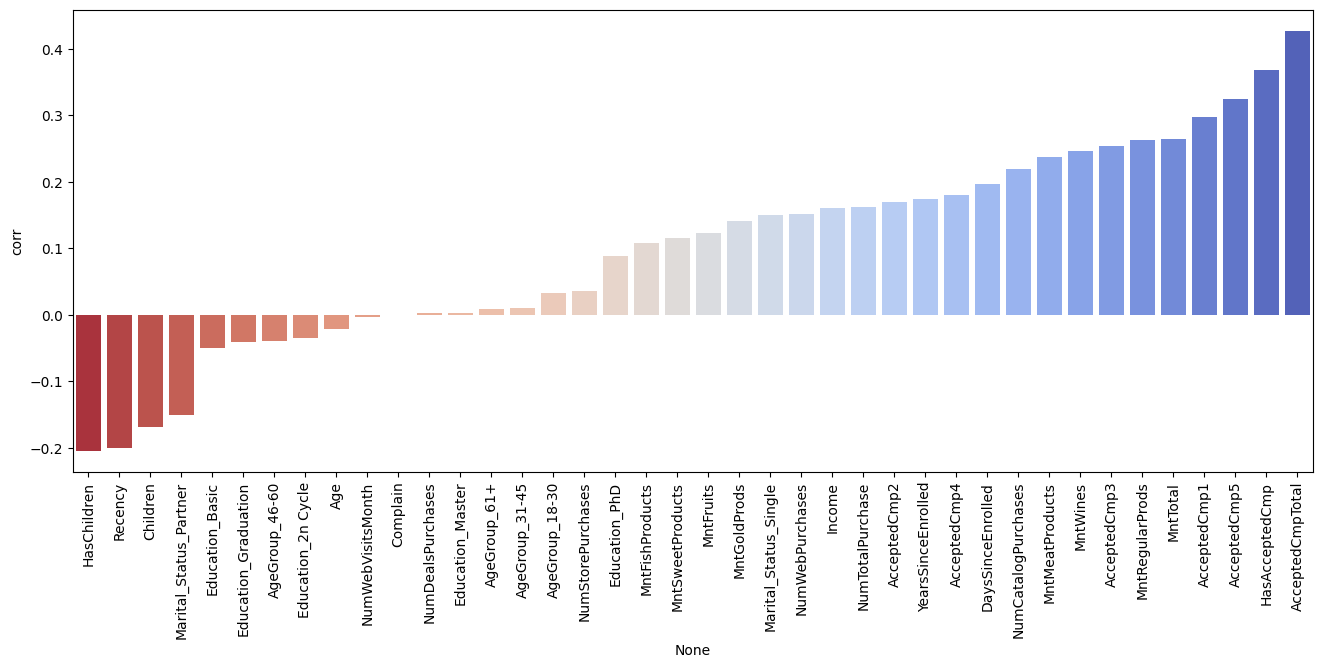

In [63]:
# correlacao da Response com demais colunas
response_corr = df_dummies_corr_unstack.loc["Response"].sort_values(by="corr")[:-1]

fig, ax = plt.subplots(figsize=(16,6))

b = sns.barplot(x=response_corr.index, y=response_corr['corr'] , palette='coolwarm_r')

b.tick_params(axis='x' , rotation=90)

plt.show()

# 5.0 - Data Preparation

In [64]:
df5 = df4.copy()

In [65]:
# selecionando as colunas numericas
numerical_features = df5.select_dtypes(include= 'number').columns

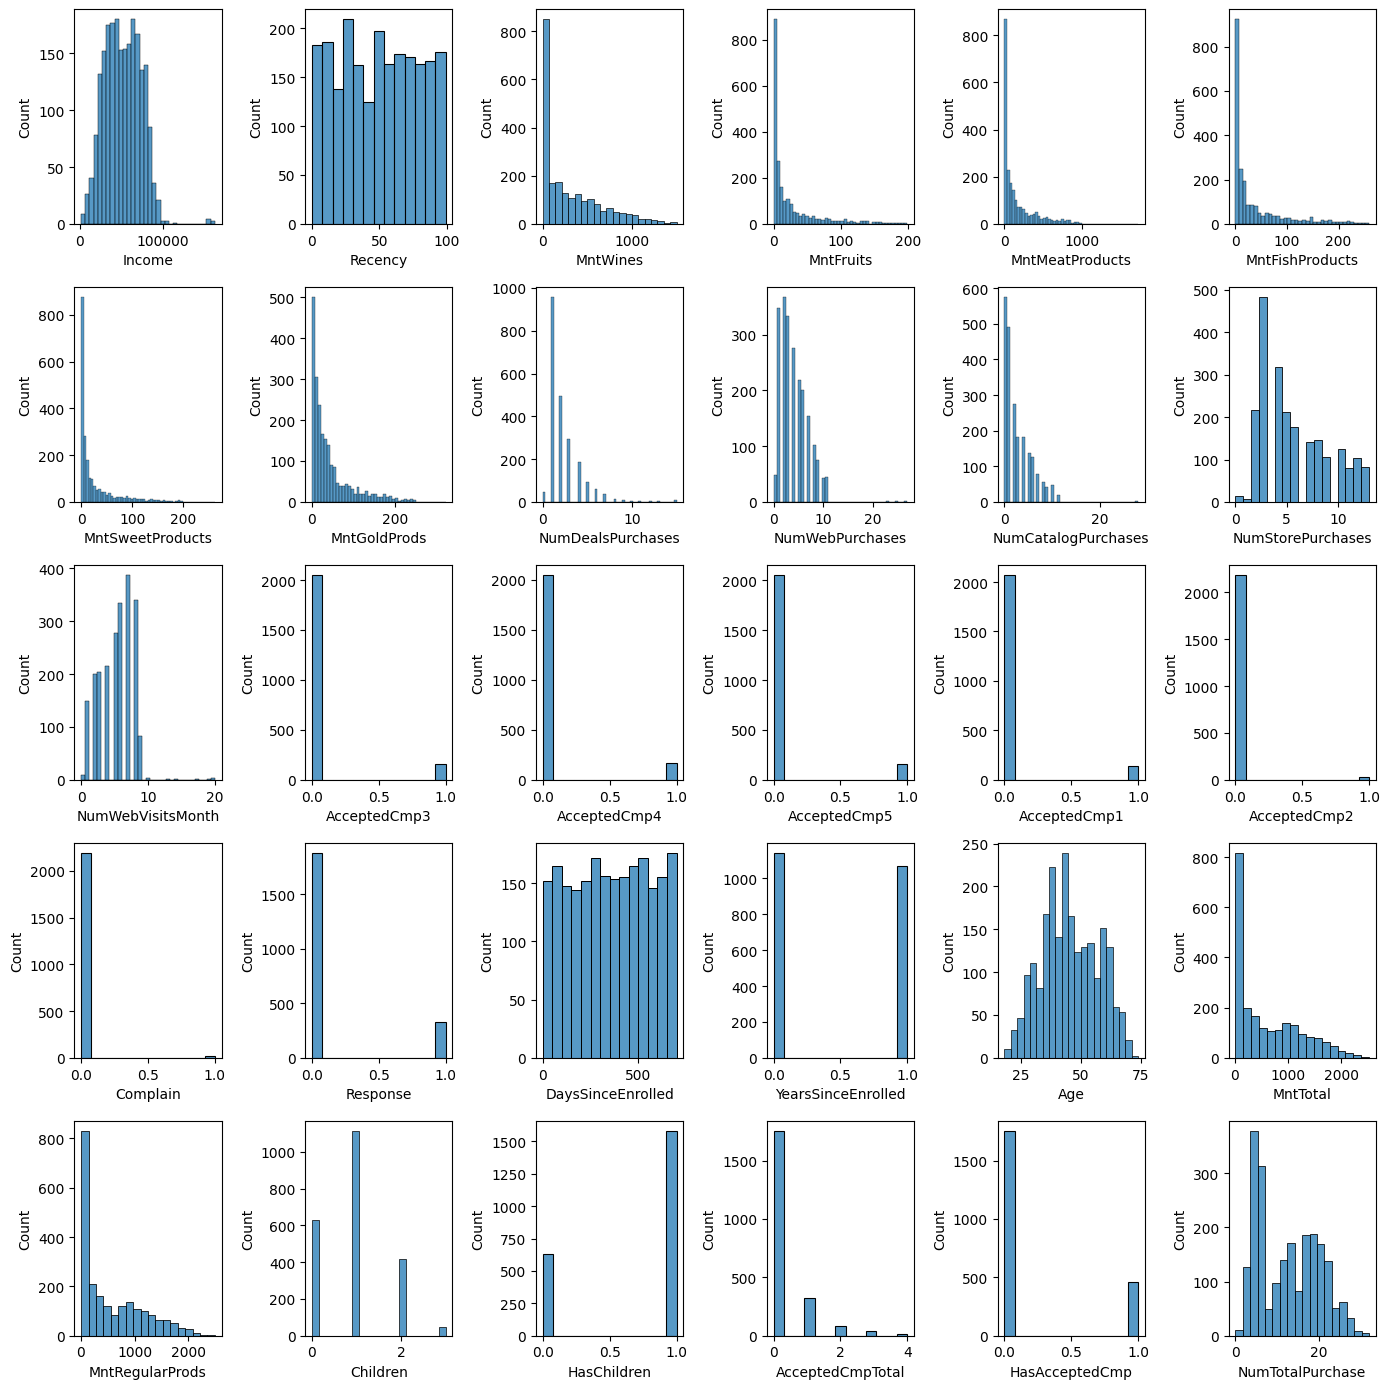

In [66]:
# visualizando a distribuição de cada feature numérica

fig, axs = plt.subplots( nrows=5, ncols=6 , figsize=(14,14) , tight_layout = True)

for ax, feature in zip(axs.flatten() , numerical_features):
    sns.histplot(x=feature , ax=ax , data=df5)

One Hot Encoder - é uma técnica do scikit-learn que transforma variáveis categóricas em um formato numérico

In [67]:
# colunas que vão receber o método One Hot Encoder
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Response",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
]


Standard Scaler - Utilizando essa técnica pois as colunas possuem, aproximadamente, uma distribuição normal 

In [68]:
standard_cols = [
    "Income",
    "Age",
]

Power Transformer -  Utilizando com o objetivo de torná-los os dados mais gaussianos (ou seja, com distribuição normal)

In [69]:
power_cols = df5.columns[
   df5.columns.str.startswith("Mnt") | df5.columns.str.startswith("Num")
].tolist()

Min Max Scaler - redimensionando cada característica (feature) para que seus valores mínimo e máximo sejam mapeados para 0 e 1, respectivamente.

In [70]:
minmax_cols = [
    col for col in df5.columns if col not in one_hot_cols + standard_cols + power_cols
]

Transformando as colunas 

In [71]:
preprocessing = ColumnTransformer(
    [
        ("one-hot" , OneHotEncoder() , one_hot_cols),
        ("standard", StandardScaler(), standard_cols),
        ("minmax", MinMaxScaler(), minmax_cols),
        ("power" , PowerTransformer(), power_cols)
    ]
)

Dataframe com as colunas em nova escala

In [72]:
df5_scaled = pd.DataFrame(
    preprocessing.fit_transform(df5),
    columns=preprocessing.get_feature_names_out()
)



# 6.0 Model Clustering

In [73]:
df6 = df5.copy()

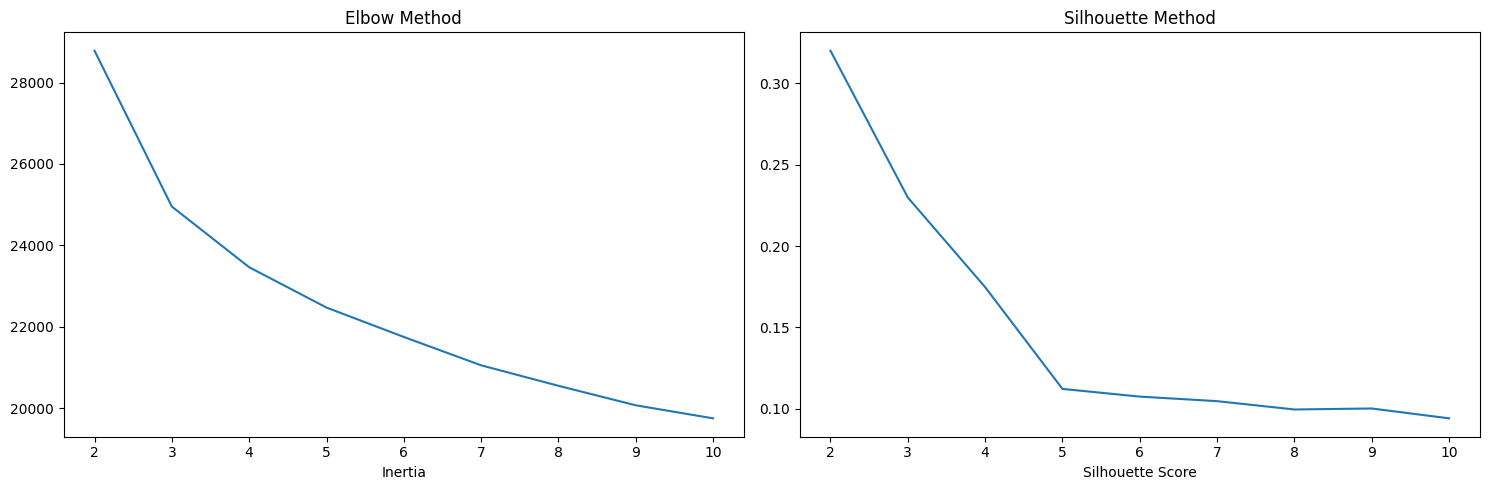

In [74]:
#Visualizacao grafica elbow e silhouette 
plot_elbow_silhouette ( df5_scaled)

A escolha sera de 3 cluster devido ao fato de ter uma cotovelo no grafico Elbow Method considerando tambem o valor de Silhouette

## 6.1 - Pipeline

**Com o pipeline é possível obter código mais organizado e modularizado, padronização na preparação de dados e modelagem, fácil aplicação do modelo treinado em novos dados, inspeção simplificada de parâmetros e etapas, e evitar vazamento entre dados de treino e teste.**

In [75]:
pipeline = Pipeline(
    [
        ("preprocessing" , preprocessing),
        ("pca" , PCA(n_components=2, random_state=42)),
        ("clustering" , KMeans( n_clusters= 3 , random_state= 42 , n_init=10))
    ]
)

pipeline.fit(df6)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Response',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal']),
                                                 ('standard', StandardScaler(),
                                                  ['Incom...
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal',
                                                   'MntRegularProds',
                                                   'NumTotalPurchase'])])),
                ('pca', PCA(n_components=2, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=3, n_init=10, random_state=42))])

In [76]:
# adicionando coluna cluster ao dataframe 
df6['cluster'] = pipeline['clustering'].labels_

In [77]:
# contagem de clientes por cluster
df6['cluster'].value_counts()

cluster
0    879
2    685
1    648
Name: count, dtype: int64

## 6.2 - PCA

**A análise de componentes principais (PCA) é uma técnica de redução de dimensionalidade linear que pode ser usada para extrair informações de um espaço de alta dimensão, projetando-as em um subespaço de dimensão inferior. Ele tenta preservar as partes essenciais que têm mais variabilidade nos dados e remover as partes não essenciais com menos variabilidade.**

In [78]:
#criacao dataframe do pca para visualizacao
df_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(df6),
    columns=pipeline[:-1].get_feature_names_out()
)



In [79]:
#centroides dos clusters
centroids = pipeline['clustering'].cluster_centers_
centroids

array([[-3.41099664, -0.36077615],
       [ 3.65251959, -0.95456567],
       [ 0.91380427,  1.37275244]])

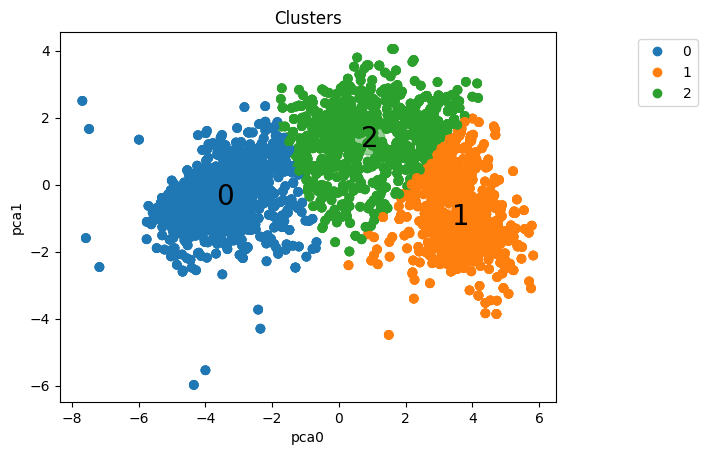

In [80]:
plot_clusters_2D(
    df_pca,
    columns= df_pca.columns,
    n_colors= 3,
    centroids=centroids,
    show_points=True,
    column_clusters=df6['cluster']
)

# 7.0 - EDA dos Cluster

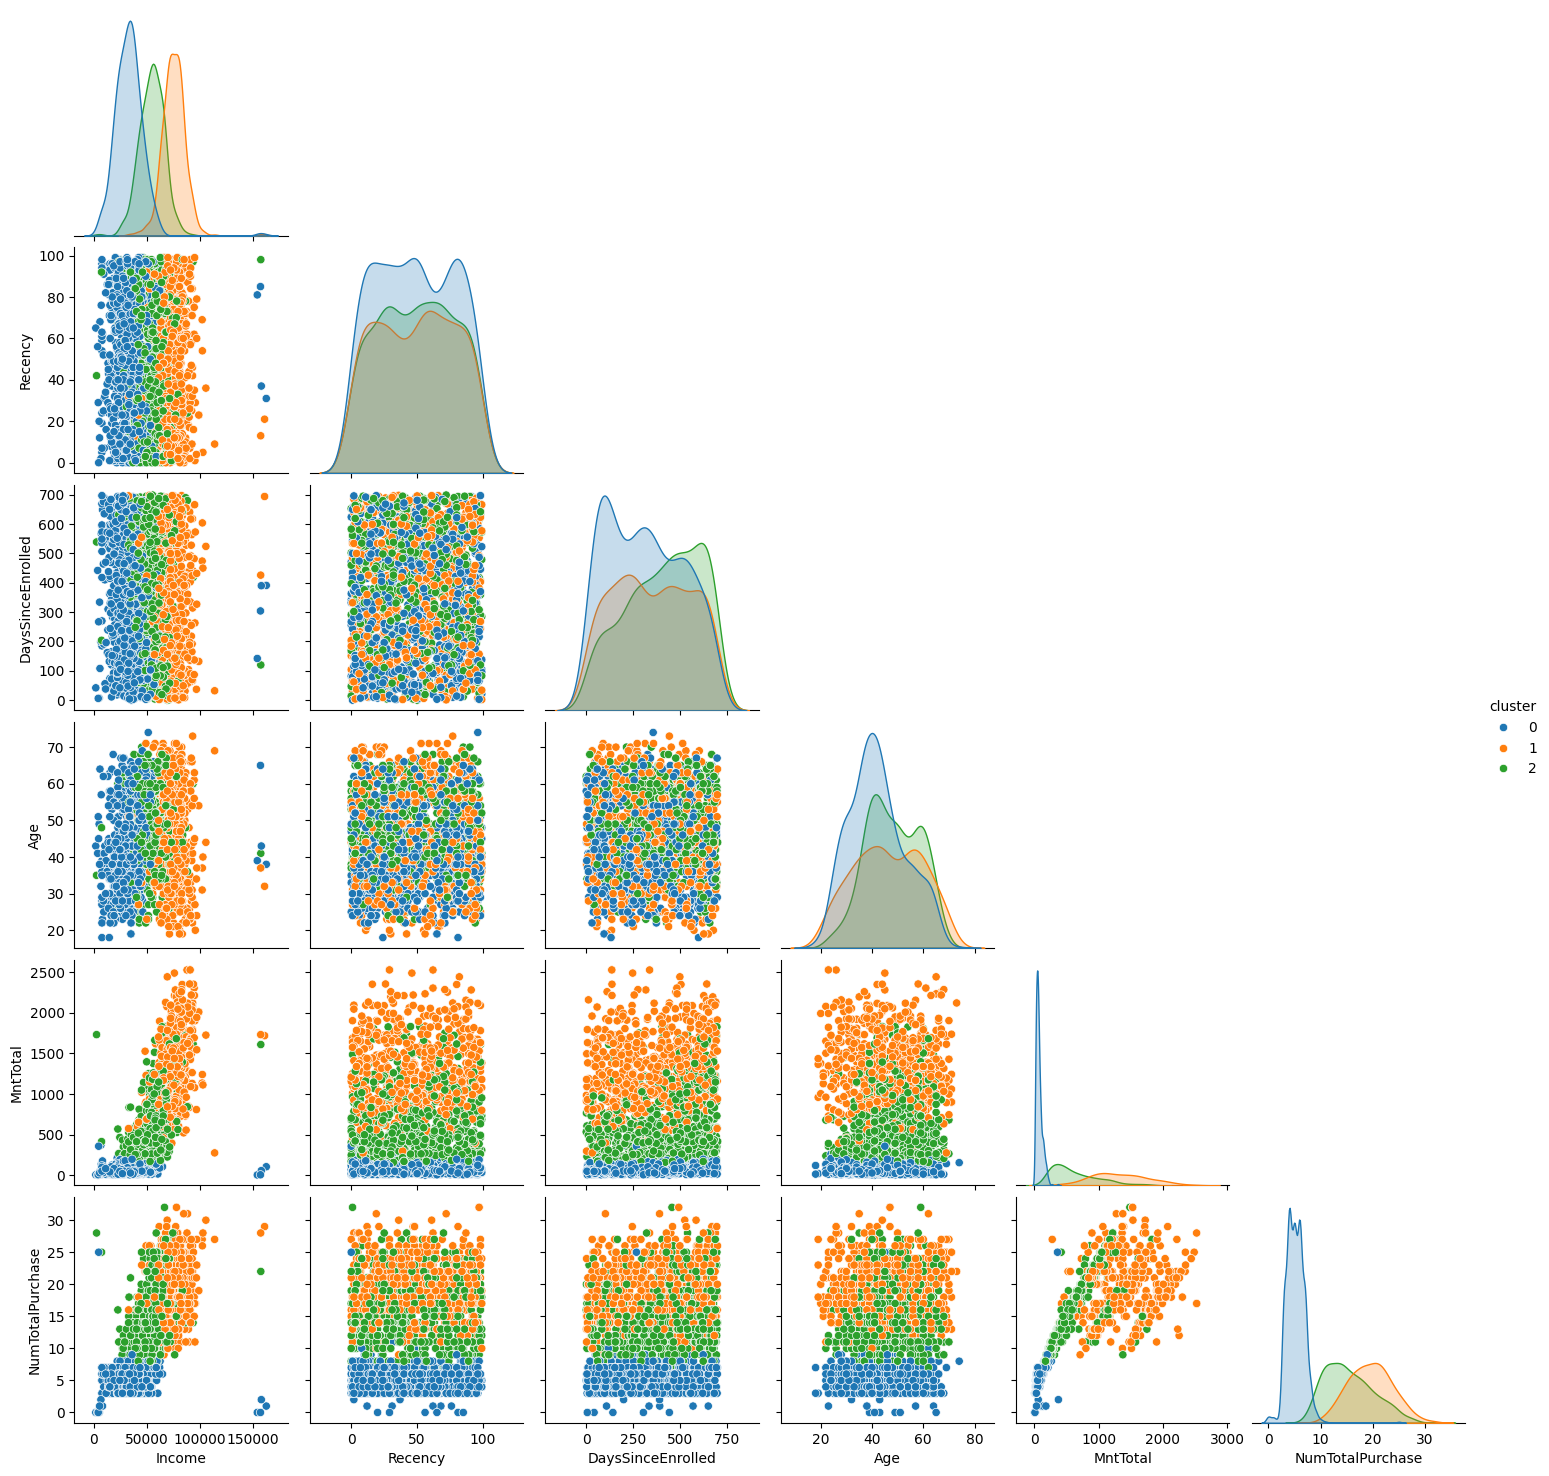

In [81]:
select_columns = [
    'Income',
    'Recency',
    'DaysSinceEnrolled',
    'Age',
    'MntTotal',
    'NumTotalPurchase',
    'cluster'
]

sns.pairplot (df6[select_columns] , diag_kind='kde' , hue = 'cluster' , corner=True ,palette= 'tab10')

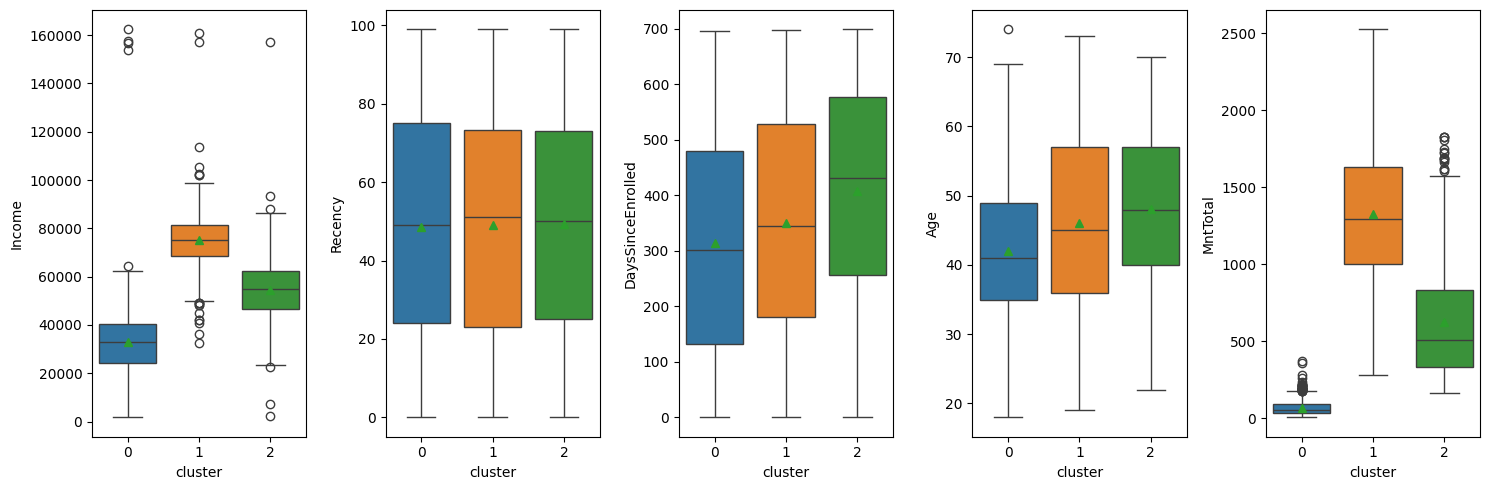

In [82]:
fig, axs = plt.subplots ( nrows=1 ,ncols = 5 , figsize=(15, 5) , tight_layout= True)

for ax , col  in zip (axs , select_columns):
    sns.boxplot( x='cluster' , y=col , data=df6 , ax =ax , showmeans = True , palette= 'tab10' );

## 7.1 - Colunas categóricas 

In [83]:
columns =[
    'HasChildren',
    'Marital_Status',
    'Education',
    'HasAcceptedCmp',
    'Response',
    'YearsSinceEnrolled'
]

#colunas que separa bem os cluster
cols_diff_cluster = ['Income' , 'MntTotal']

Visualizando os boxplot com MntTotal fixo no eixo y

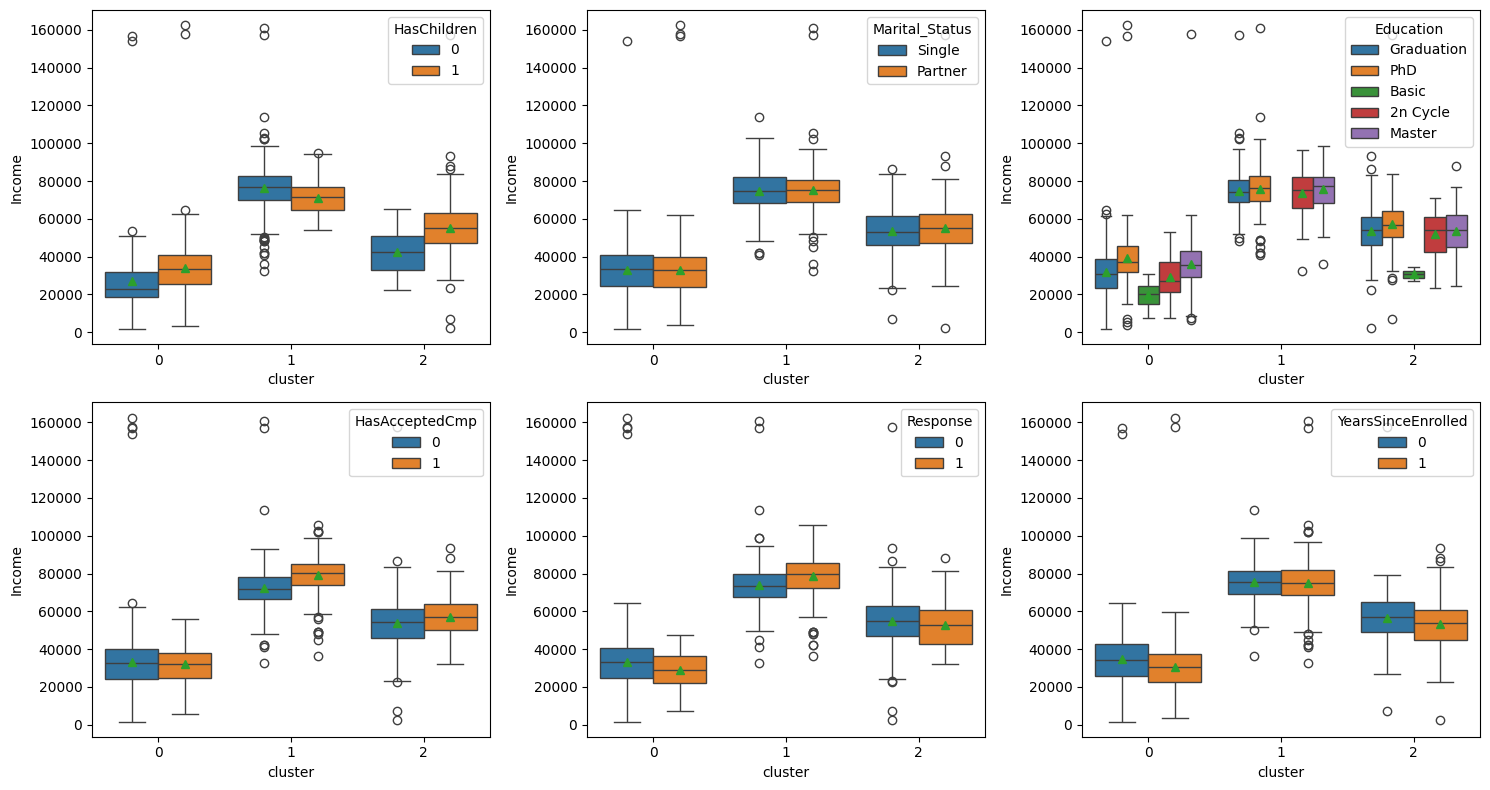

In [84]:
fig, axs = plt.subplots ( nrows=2 ,ncols = 3 , figsize=(15, 8) , tight_layout= True)

for ax , col  in zip (axs.flatten() , columns):
    sns.boxplot( x='cluster' , y=cols_diff_cluster[0] , data=df6 , ax =ax , showmeans = True , hue=col );

Visualizando os boxplot com Income fixo no eixo y

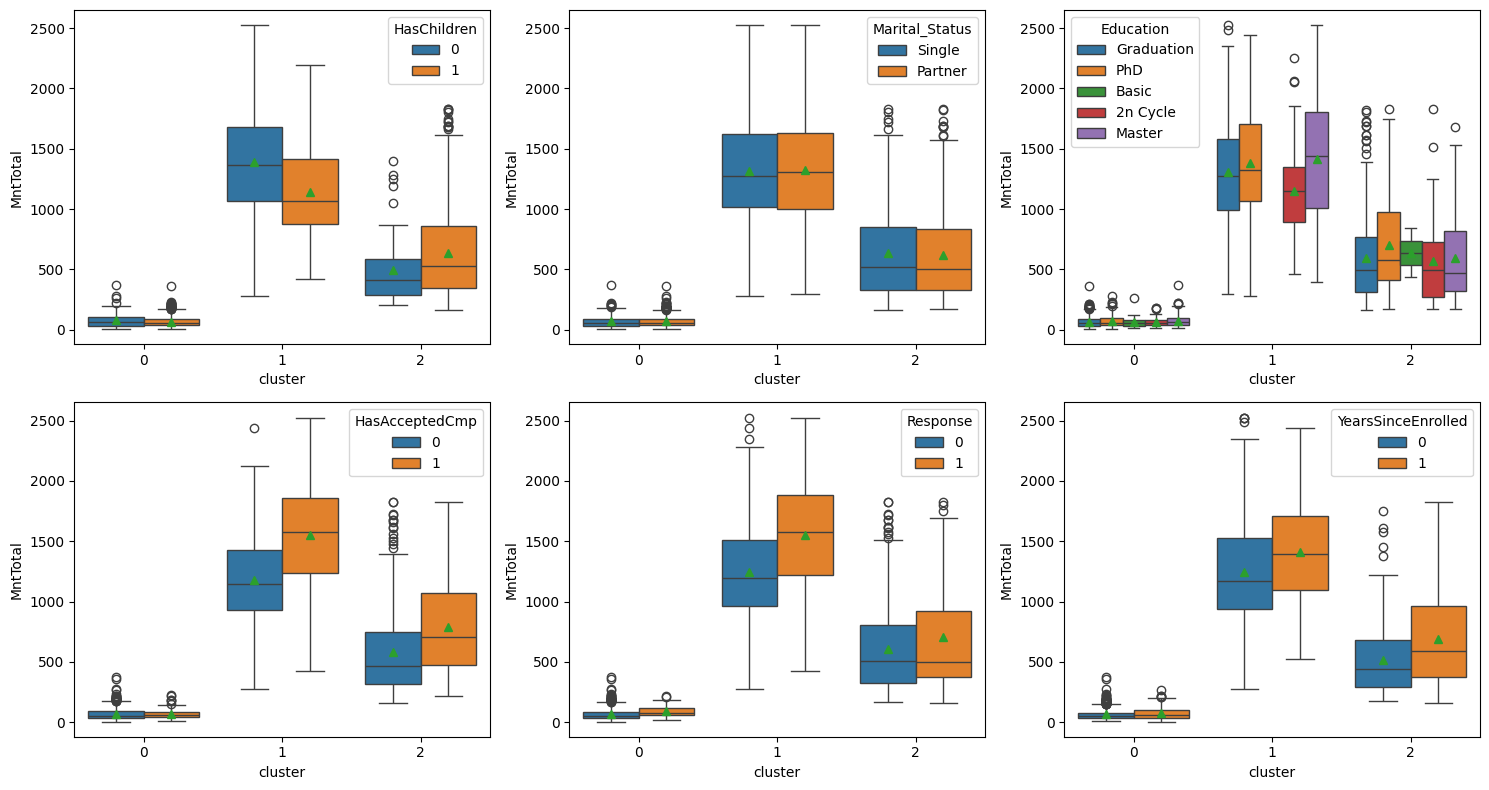

In [85]:
fig, axs = plt.subplots ( nrows=2 ,ncols = 3, figsize=(15, 8) , tight_layout= True)

for ax , col  in zip (axs.flatten() , columns):
    sns.boxplot( x='cluster' , y=cols_diff_cluster[1] , data=df6 , ax =ax , showmeans = True , hue=col );

Visualizaçã gráfica para obter a idéia de proporção das colunas nos cluster

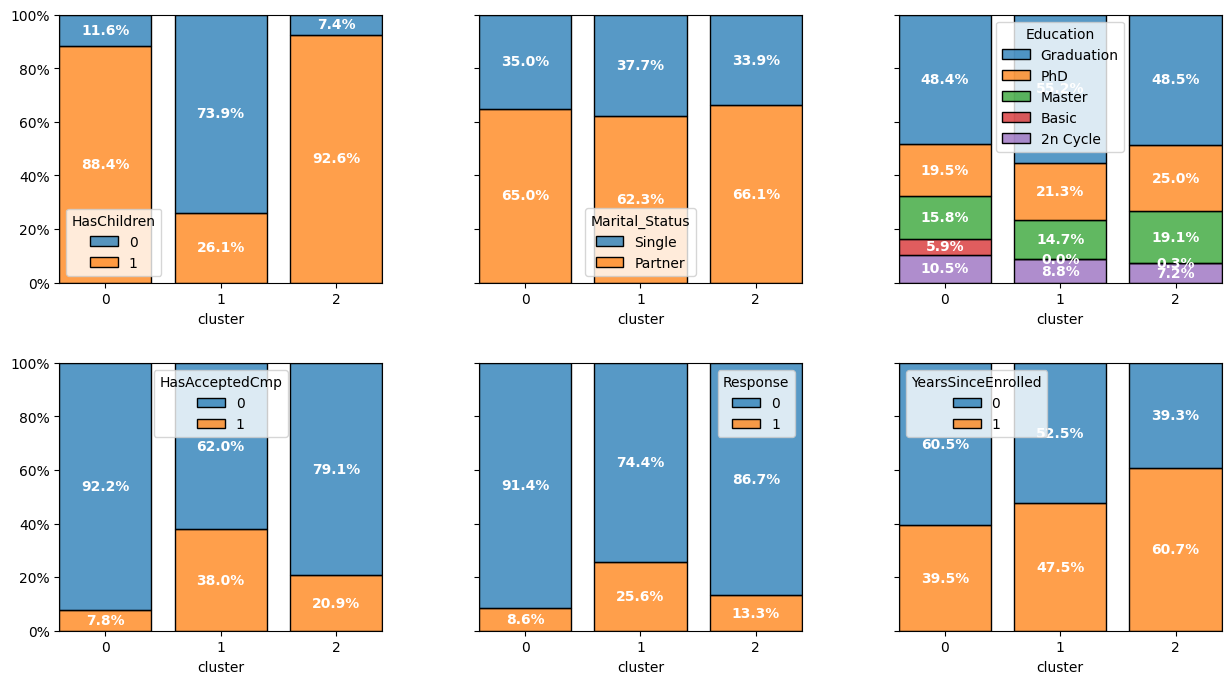

In [86]:
fig, axs = plt.subplots ( nrows=2 ,ncols = 3, figsize=(15, 8) ,sharey=True)

for ax , col  in zip (axs.flatten() , columns):
   h = sns.histplot( x='cluster' , hue=col , data=df6 , ax =ax , multiple='fill' , stat='percent' ,discrete=True ,shrink=0.8)

   n_clusters = df6['cluster'].nunique()
   h.set_xticks(range(n_clusters))
   h.yaxis.set_major_formatter(PercentFormatter(1))
   h.set_ylabel("")

   for bars in h.containers:
      h.bar_label( bars , label_type='center' , labels=[f'{b.get_height():.1%}' for b in bars] , color='white' ,weight='bold')
plt.subplots_adjust( hspace=0.3 ,wspace=0.3)
plt.show()
   

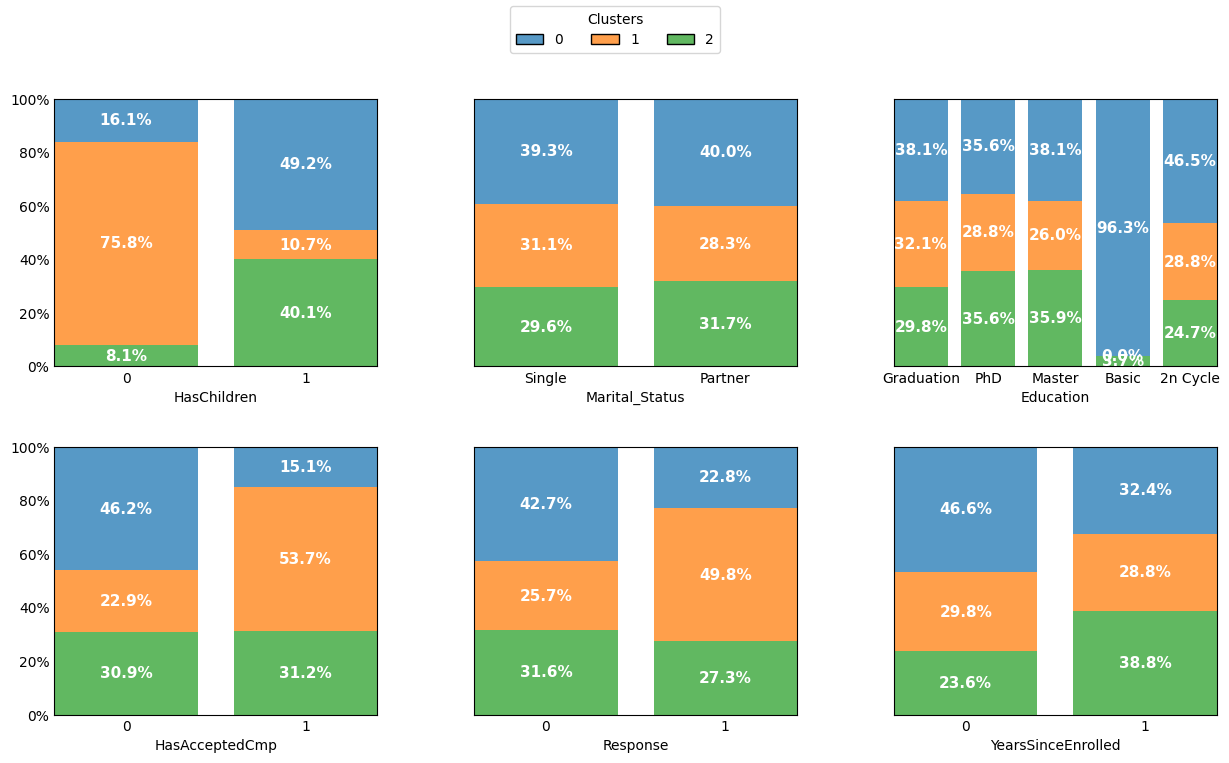

In [87]:
plot_columns_percent_hue_cluster(
    df6,
    columns,
)

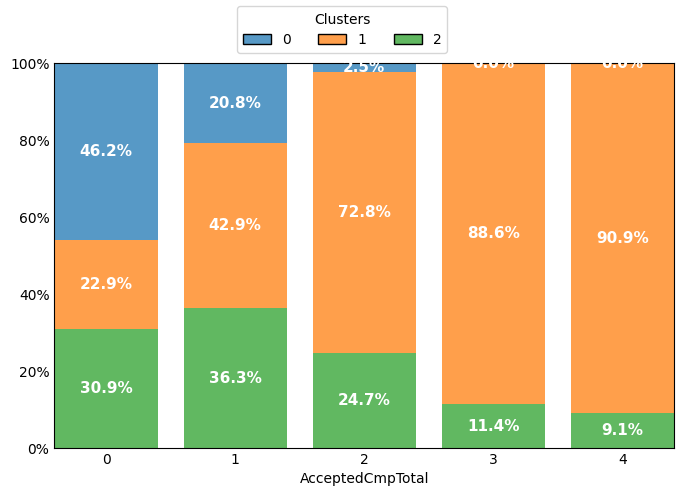

In [88]:
plot_columns_percent_hue_cluster(
    df6,
    ['AcceptedCmpTotal'],
    rows_cols=(1,1),
    figsize=(8,5)
)


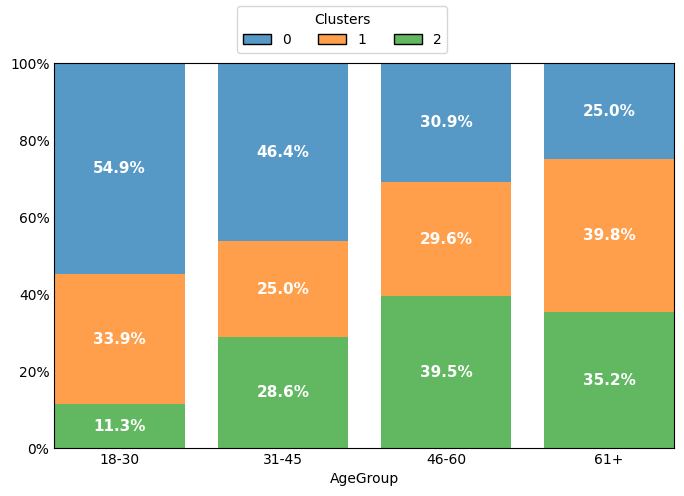

In [89]:
plot_columns_percent_hue_cluster(
    df6,
    ['AgeGroup'],
    rows_cols=(1,1),
    figsize=(8,5)
)

Análise por cluster:

- Cluster 0: 
  - Renda alta 
  - gasto alto 
  - muito provalmente não tem filhos
  - mais propenso a aceitar campanhas
  - cluster sem pessoas com escolaridade básica
  - sem um perfil de idade que se destaque
  

- Cluster 1: 
  - Renda baixa 
  - gasto baixo 
  - provalmente tem filhos
  - baixa propensão a aceitar campanhas
  - único cluster com porcentagem significativa de pessoas com escolaridade básica
  - pessoas mais jovens
  

- Cluster 2: 
  - Renda intermediária
  - gasto intermediário
  - provalmente tem filhos
  - pode aceitar campanhas
  - pessoas com idade mais elevada